In [3]:
!pip install pdpbox

In [58]:
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 8.1 MB/s eta 0:00:00


In [4]:
!pip install alibi

In [59]:
import pandas as pd
from sklearn.metrics import f1_score
from lime import lime_tabular
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from lime import lime_image
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from tensorflow import keras
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import layers
import shap
from pdpbox import pdp
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale
import scipy.stats as stats
from scipy.stats import shapiro


In [6]:
cs_train = pd.read_csv('cs-training.csv')
cs_train = cs_train.iloc[:50000].copy()
print("\nDataset dimensions:", cs_train.shape)
print("\nColumn information:")
for col in cs_train.columns:
    print(f"- {col}: {cs_train[col].dtype}")


Dataset dimensions: (50000, 12)

Column information:
- Unnamed: 0: int64
- SeriousDlqin2yrs: int64
- RevolvingUtilizationOfUnsecuredLines: float64
- age: int64
- NumberOfTime30-59DaysPastDueNotWorse: int64
- DebtRatio: float64
- MonthlyIncome: float64
- NumberOfOpenCreditLinesAndLoans: int64
- NumberOfTimes90DaysLate: int64
- NumberRealEstateLoansOrLines: int64
- NumberOfTime60-89DaysPastDueNotWorse: int64
- NumberOfDependents: float64


In [7]:
!pip install shap lime matplotlib seaborn torch torchvision opencv-python

In [8]:
cs_train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [9]:
cs_train.isnull().sum()


,0
Unnamed: 0,0
SeriousDlqin2yrs,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
DebtRatio,0
MonthlyIncome,10004
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0


In [10]:
if 'Unnamed: 0' in cs_train.columns:
    cs_train.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
cs_train['MonthlyIncome'].fillna(cs_train['MonthlyIncome'].median(), inplace=True)
cs_train['NumberOfDependents'].fillna(cs_train['NumberOfDependents'].median(), inplace=True)

In [12]:
cs_train.isnull().sum()


,0
SeriousDlqin2yrs,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
NumberOfTime30-59DaysPastDueNotWorse,0
DebtRatio,0
MonthlyIncome,0
NumberOfOpenCreditLinesAndLoans,0
NumberOfTimes90DaysLate,0
NumberRealEstateLoansOrLines,0
NumberOfTime60-89DaysPastDueNotWorse,0


In [13]:
cs_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.066940,5.140053,52.210200,0.427700,360.093462,6365.310820,8.420480,0.276600,1.016280,0.249020,0.738380
std,0.249921,220.446381,14.792364,4.290205,2070.454856,7300.202296,5.128751,4.267207,1.128202,4.254016,1.110207
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029884,41.000000,0.000000,0.175006,3912.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.157143,52.000000,0.000000,0.367364,5388.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.563820,63.000000,0.000000,0.876061,7355.250000,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,29110.000000,107.000000,98.000000,326442.000000,629000.000000,58.000000,98.000000,54.000000,98.000000,20.000000


In [14]:
max_debt_ratio = cs_train['DebtRatio'].quantile(0.99)
cs_train['DebtRatio'] = cs_train['DebtRatio'].apply(lambda x: max_debt_ratio if x > max_debt_ratio else x)

max_revolving = cs_train['RevolvingUtilizationOfUnsecuredLines'].quantile(0.99)
cs_train['RevolvingUtilizationOfUnsecuredLines'] = cs_train['RevolvingUtilizationOfUnsecuredLines'].apply(
    lambda x: max_revolving if x > max_revolving else x
)


print(cs_train.describe())

       SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines           age  \
count      50000.000000                          50000.000000  50000.000000   
mean           0.066940                              0.323073     52.210200   
std            0.249921                              0.353953     14.792364   
min            0.000000                              0.000000     21.000000   
25%            0.000000                              0.029884     41.000000   
50%            0.000000                              0.157143     52.000000   
75%            0.000000                              0.563820     63.000000   
max            1.000000                              1.086390    107.000000   

       NumberOfTime30-59DaysPastDueNotWorse     DebtRatio  MonthlyIncome  \
count                          50000.000000  50000.000000   50000.000000   
mean                               0.427700    323.357622    6365.310820   
std                                4.290205    921.532967   

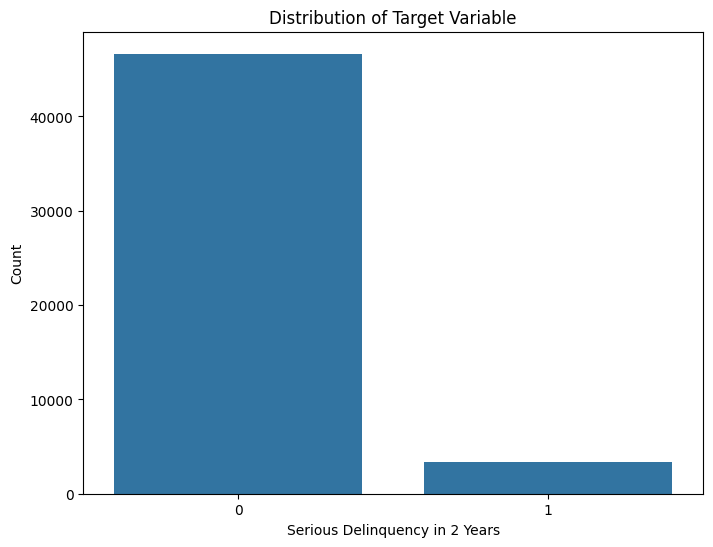

Target Variable Distribution:
SeriousDlqin2yrs
0    93.306
1     6.694
Name: count, dtype: float64


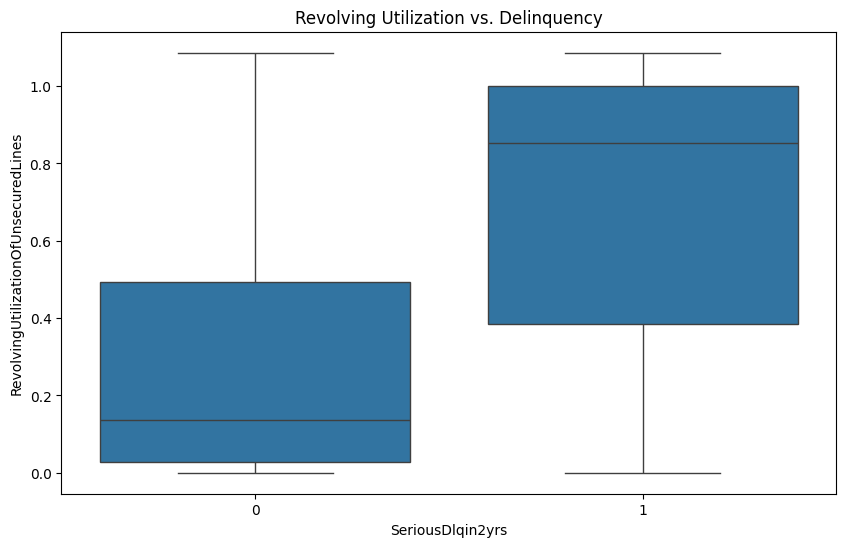

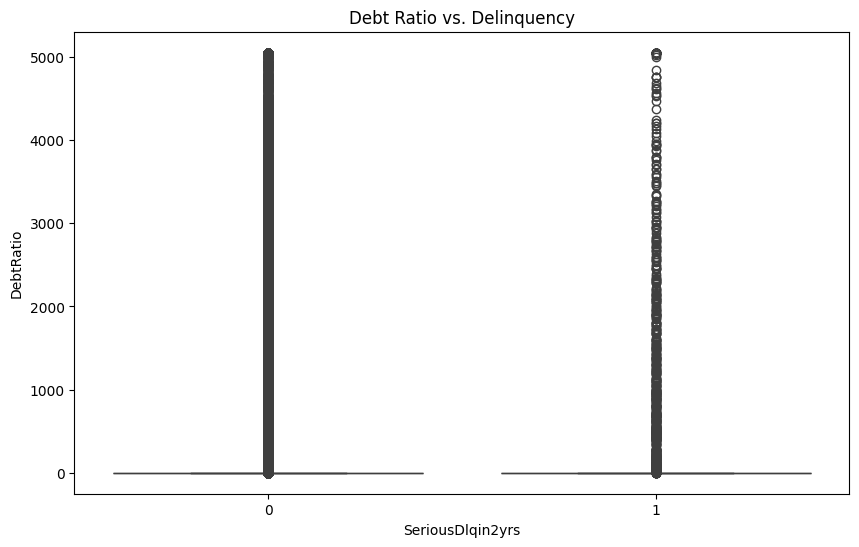

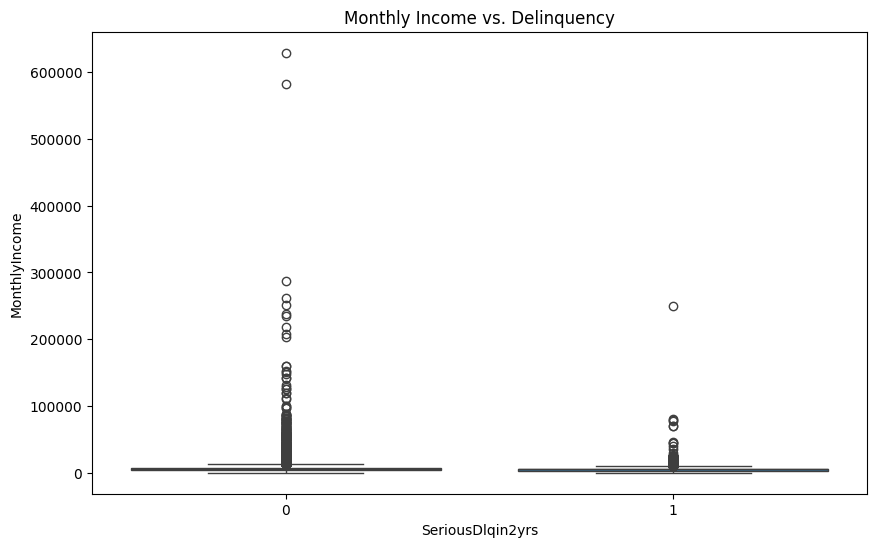

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(x='SeriousDlqin2yrs', data=cs_train)
plt.title('Distribution of Target Variable')
plt.xlabel('Serious Delinquency in 2 Years')
plt.ylabel('Count')
plt.show()

target_counts = cs_train['SeriousDlqin2yrs'].value_counts()
target_percentages = target_counts / len(cs_train) * 100
print(f"Target Variable Distribution:\n{target_percentages}")

plt.figure(figsize=(10, 6))
sns.boxplot(x='SeriousDlqin2yrs', y='RevolvingUtilizationOfUnsecuredLines', data=cs_train)
plt.title('Revolving Utilization vs. Delinquency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='SeriousDlqin2yrs', y='DebtRatio', data=cs_train)
plt.title('Debt Ratio vs. Delinquency')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='SeriousDlqin2yrs', y='MonthlyIncome', data=cs_train)
plt.title('Monthly Income vs. Delinquency')
plt.show()



Analyzing feature distributions:


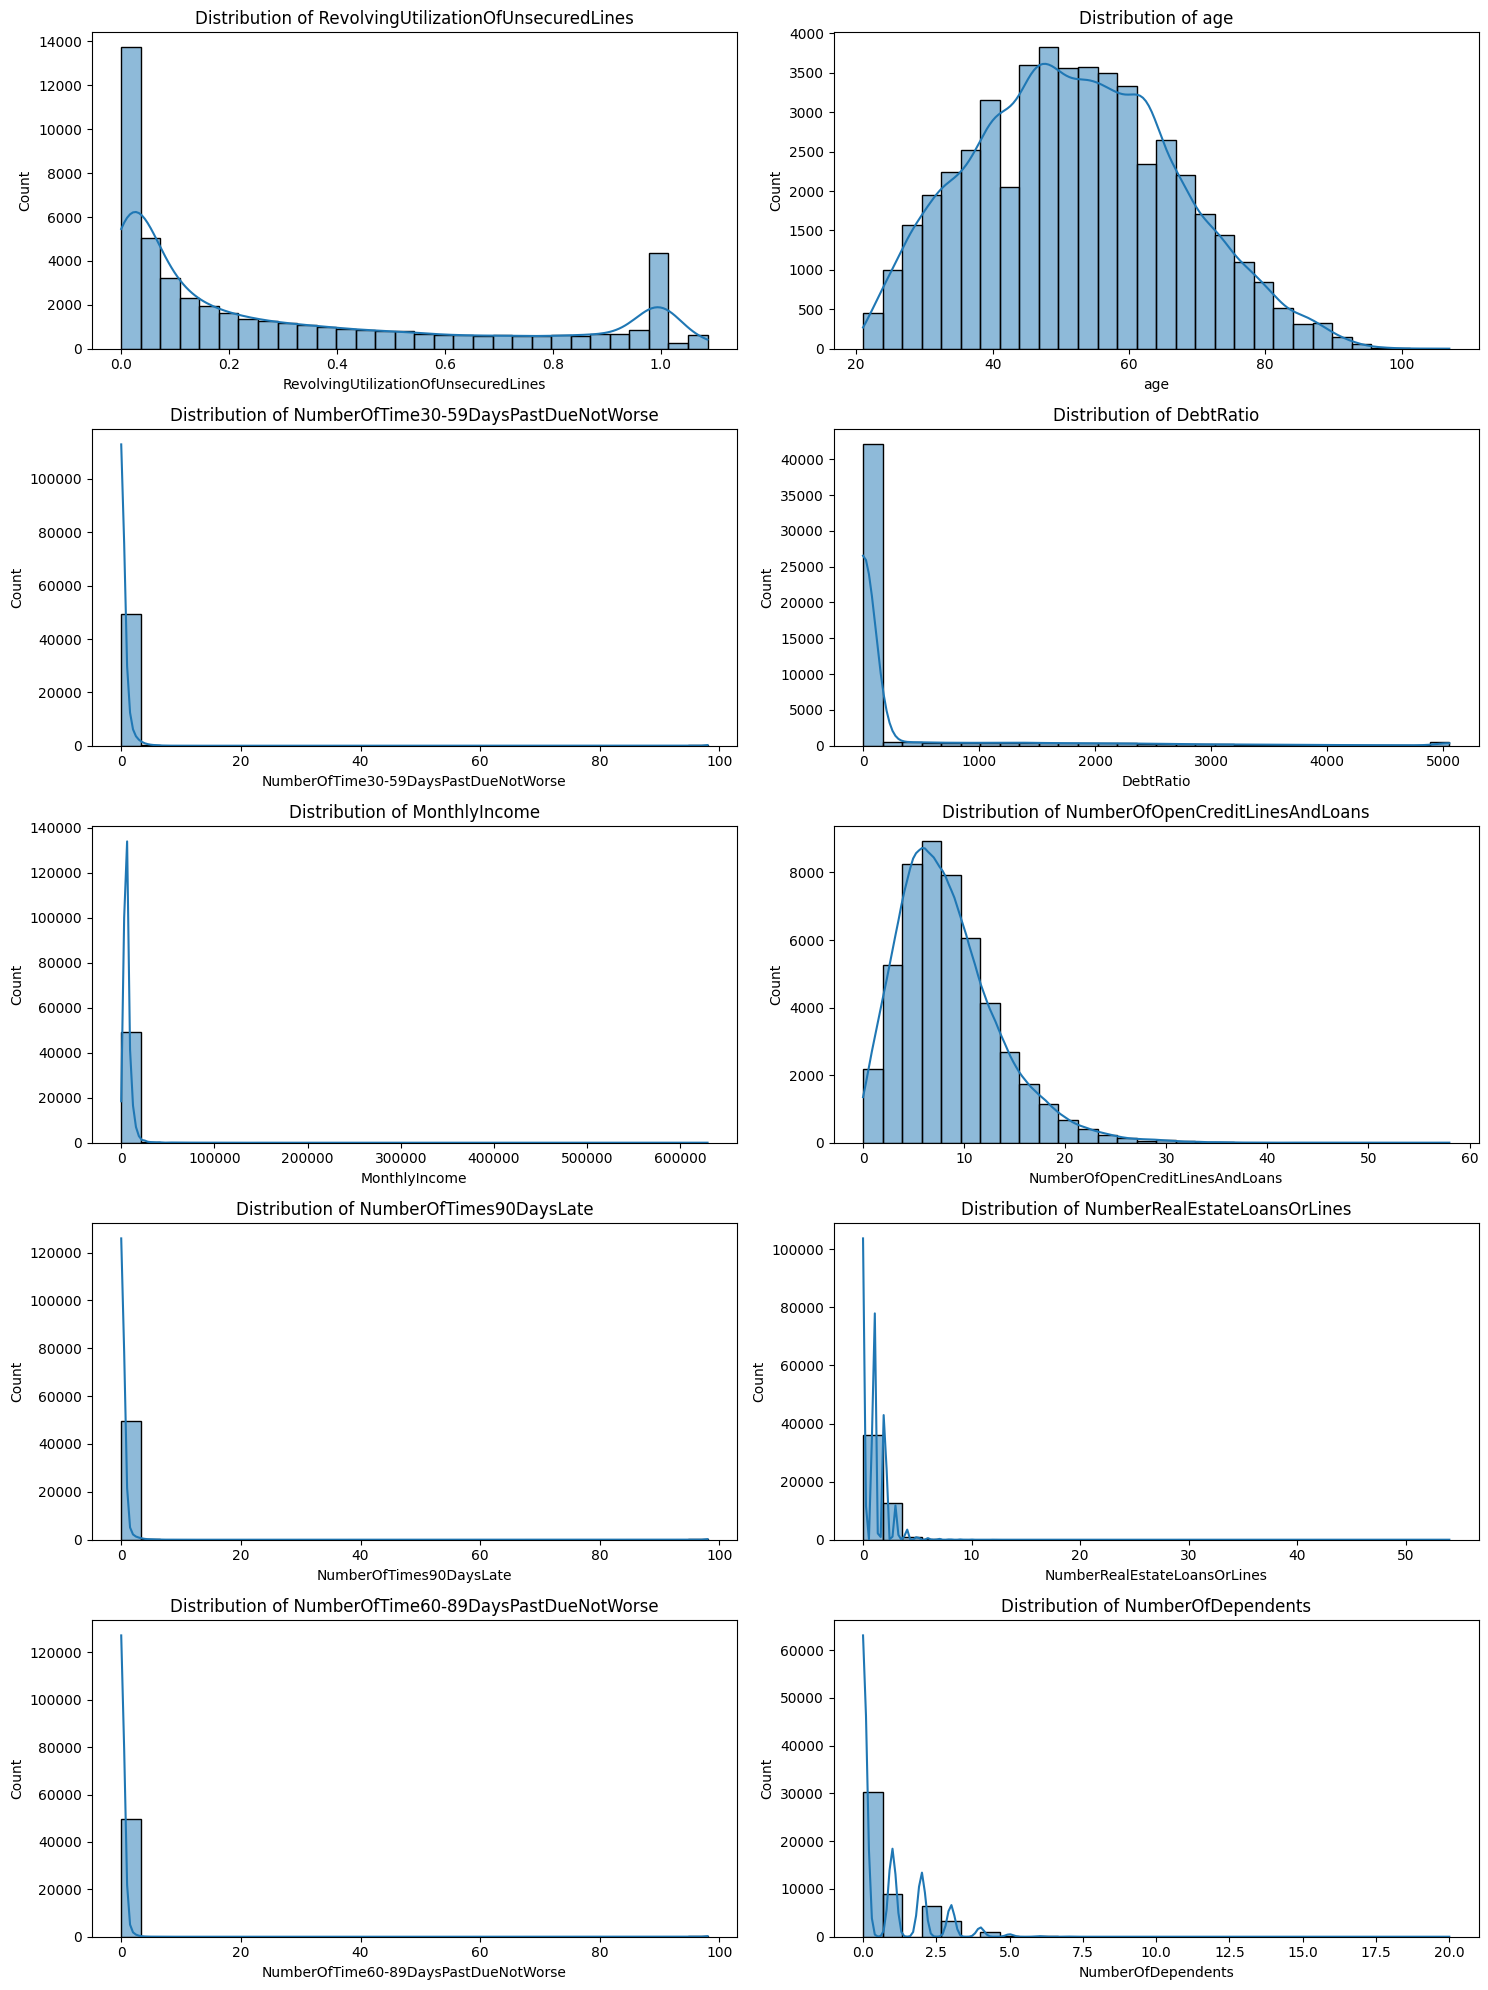

In [16]:
def plot_histograms(df, columns, bins=30):
    n_cols = 2
    n_rows = (len(columns) + 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        if i < len(axes):
            sns.histplot(df[col], bins=bins, kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')

    # Hide any unused subplots
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Separate numerical and categorical features
numerical_features = cs_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('SeriousDlqin2yrs')  # Remove target variable

print("\nAnalyzing feature distributions:")
plot_histograms(cs_train, numerical_features)

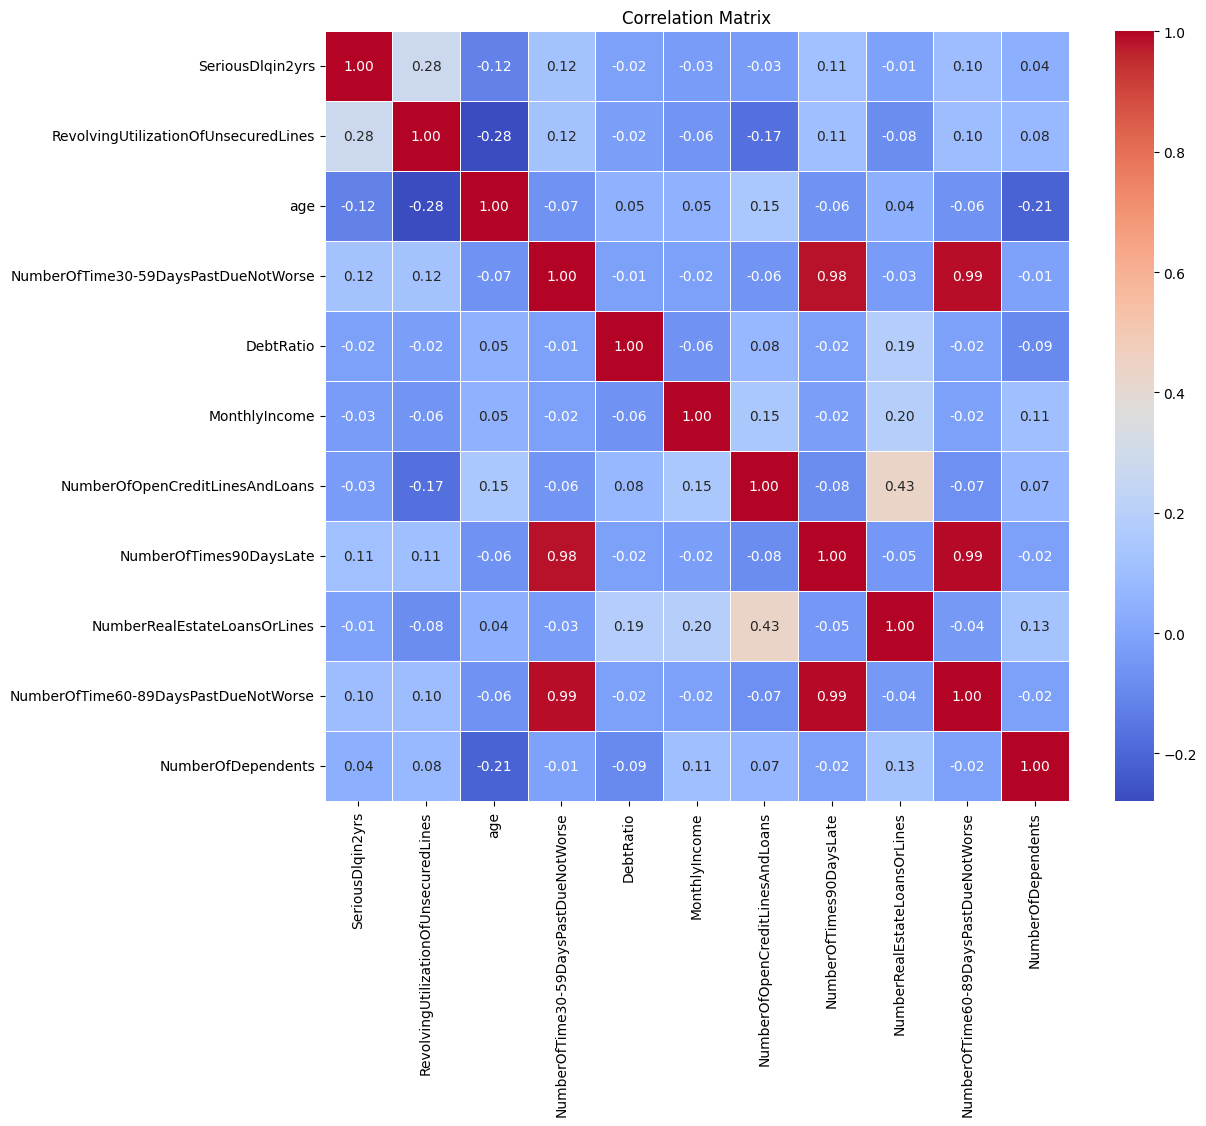


Features most correlated with target:
SeriousDlqin2yrs                        1.000000
RevolvingUtilizationOfUnsecuredLines    0.277712
NumberOfTime30-59DaysPastDueNotWorse    0.120604
NumberOfTimes90DaysLate                 0.113803
NumberOfTime60-89DaysPastDueNotWorse    0.099451
NumberOfDependents                      0.038899
NumberRealEstateLoansOrLines           -0.013867
DebtRatio                              -0.017474
MonthlyIncome                          -0.030857
NumberOfOpenCreditLinesAndLoans        -0.034021
age                                    -0.115318
Name: SeriousDlqin2yrs, dtype: float64


In [17]:
plt.figure(figsize=(12, 10))
correlation_matrix = cs_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

print("\nFeatures most correlated with target:")
target_correlations = correlation_matrix['SeriousDlqin2yrs'].sort_values(ascending=False)
print(target_correlations)

# **Feature selection and Engineering**

### **Feature Engineering**

In [18]:

cs_train['Utilization_DebtRatio'] = cs_train['RevolvingUtilizationOfUnsecuredLines'] * cs_train['DebtRatio']
cs_train['Total_Past_Due'] = (cs_train['NumberOfTime30-59DaysPastDueNotWorse'] +
                                     cs_train['NumberOfTime60-89DaysPastDueNotWorse'] +
                                     cs_train['NumberOfTimes90DaysLate'])
cs_train['Age_Dependents_Ratio'] = cs_train['age'] / (cs_train['NumberOfDependents'] + 1)
cs_train['Credit_Per_Income'] = cs_train['NumberOfOpenCreditLinesAndLoans'] / (cs_train['MonthlyIncome'] + 1)
cs_train['Credit_Per_Person'] = cs_train['NumberOfOpenCreditLinesAndLoans'] / (cs_train['NumberOfDependents'] + 1)

# Log transformations to address skewness and potential non-linearity
cs_train['RevolvingUtilization_Log'] = np.log1p(cs_train['RevolvingUtilizationOfUnsecuredLines'])
cs_train['DebtRatio_Log'] = np.log1p(cs_train['DebtRatio'])
cs_train['MonthlyIncome_Log'] = np.log1p(cs_train['MonthlyIncome'])

print("New features created!")
for col in cs_train.columns:
    if col not in cs_train.columns:
        print(f"- {col}")


New features created!


### **Feature Selection using Wrapper**

In [19]:
X = cs_train.drop('SeriousDlqin2yrs', axis=1)
y = cs_train['SeriousDlqin2yrs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
lr = LogisticRegression(max_iter=1000, random_state=42)

sfs_forward = SFS(lr,
                 k_features=10,
                 forward=True,
                 floating=False,
                 scoring='roc_auc',
                 cv=5,
                 n_jobs=-1)

sfs_forward.fit(X_train, y_train)


SequentialFeatureSelector(estimator=LogisticRegression(max_iter=1000,
                                                       random_state=42),
                          k_features=(10, 10), n_jobs=-1, scoring='roc_auc')

In [21]:
forward_features = list(X_train.columns[list(sfs_forward.k_feature_idx_)])
print("Features selected by Forward Selection:")
for i, feature in enumerate(forward_features, 1):
    print(f"{i}. {feature}")


Features selected by Forward Selection:
1. RevolvingUtilizationOfUnsecuredLines
2. age
3. DebtRatio
4. MonthlyIncome
5. NumberOfOpenCreditLinesAndLoans
6. NumberRealEstateLoansOrLines
7. NumberOfTime60-89DaysPastDueNotWorse
8. Total_Past_Due
9. Credit_Per_Income
10. RevolvingUtilization_Log


In [22]:
lr_rfe = LogisticRegression(max_iter=1000, random_state=42)

rfe = RFE(estimator=lr_rfe,
          n_features_to_select=10,
          step=1)

rfe.fit(X_train, y_train)

rfe_features = X_train.columns[rfe.support_].tolist()
print("Features selected by RFE:")
for i, feature in enumerate(rfe_features, 1):
    print(f"{i}. {feature}")

Features selected by RFE:
1. RevolvingUtilizationOfUnsecuredLines
2. NumberOfTime30-59DaysPastDueNotWorse
3. NumberOfTimes90DaysLate
4. NumberRealEstateLoansOrLines
5. NumberOfTime60-89DaysPastDueNotWorse
6. NumberOfDependents
7. Credit_Per_Income
8. Credit_Per_Person
9. RevolvingUtilization_Log
10. MonthlyIncome_Log


### **Regression Assumptions**

In [23]:

X_train_sm = sm.add_constant(X_train[rfe_features])
X_test_sm = sm.add_constant(X_test[rfe_features])

logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit(disp=0)

print("\nModel Summary:")
print(result.summary())



Model Summary:
                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39989
Method:                           MLE   Df Model:                           10
Date:                Sat, 03 May 2025   Pseudo R-squ.:                  0.1636
Time:                        11:50:25   Log-Likelihood:                -8219.0
converged:                       True   LL-Null:                       -9827.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.7154      0.213    -17.421      0.000      -4.133      -3.297
RevolvingUtilizationOfUnsecuredLines 

In [24]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))
print("\nFeatures with VIF > 10 may indicate multicollinearity issues.")


                                 Feature         VIF
1   RevolvingUtilizationOfUnsecuredLines  139.104469
9               RevolvingUtilization_Log  138.161751
5   NumberOfTime60-89DaysPastDueNotWorse  103.284285
0                                  const  100.682717
3                NumberOfTimes90DaysLate   80.982924
2   NumberOfTime30-59DaysPastDueNotWorse   44.988879
10                     MonthlyIncome_Log    2.149951
7                      Credit_Per_Income    2.058039
8                      Credit_Per_Person    1.579010
6                     NumberOfDependents    1.451389
4           NumberRealEstateLoansOrLines    1.232623

Features with VIF > 10 may indicate multicollinearity issues.


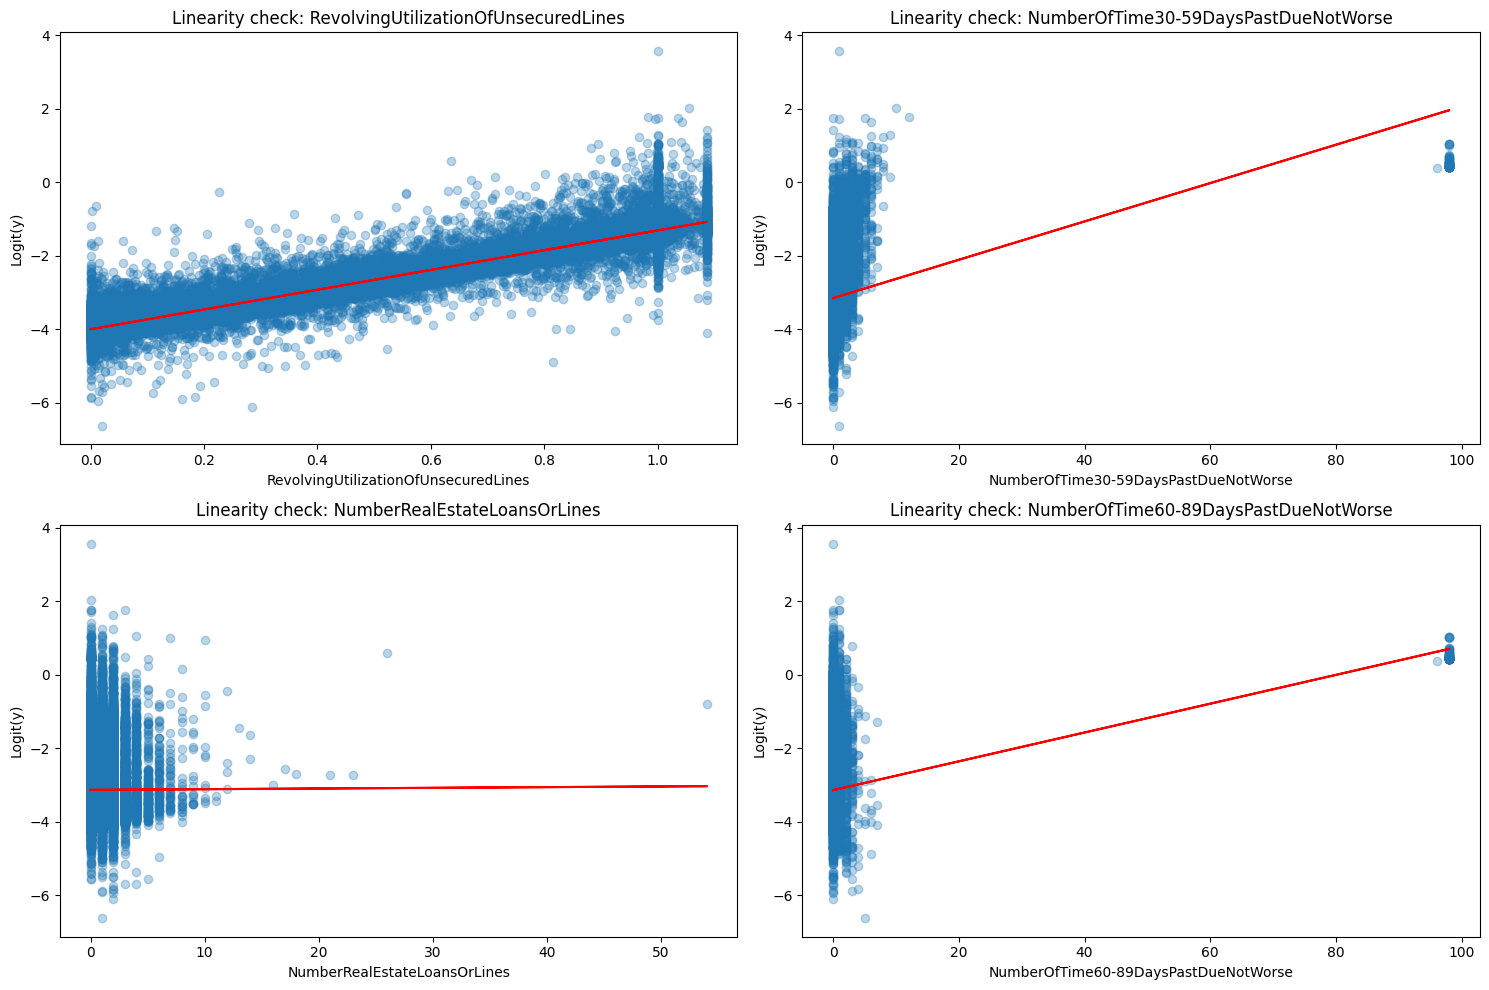

In [25]:
y_pred_proba = result.predict(X_train_sm)
logit_y = np.log(y_pred_proba / (1 - y_pred_proba))

continuous_features = [f for f in rfe_features if f not in ['NumberOfDependents', 'NumberOfTime30_59DaysPastDue',
                                                        'NumberOfTime60_89DaysPastDue', 'NumberOfTimes90DaysLate']]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(continuous_features[:4], 1):
    plt.subplot(2, 2, i)
    plt.scatter(X_train[feature], logit_y, alpha=0.3)

    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(X_train[feature], logit_y)
    plt.plot(X_train[feature], intercept + slope*X_train[feature], 'r')

    plt.title(f'Linearity check: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Logit(y)')

plt.tight_layout()
plt.show()

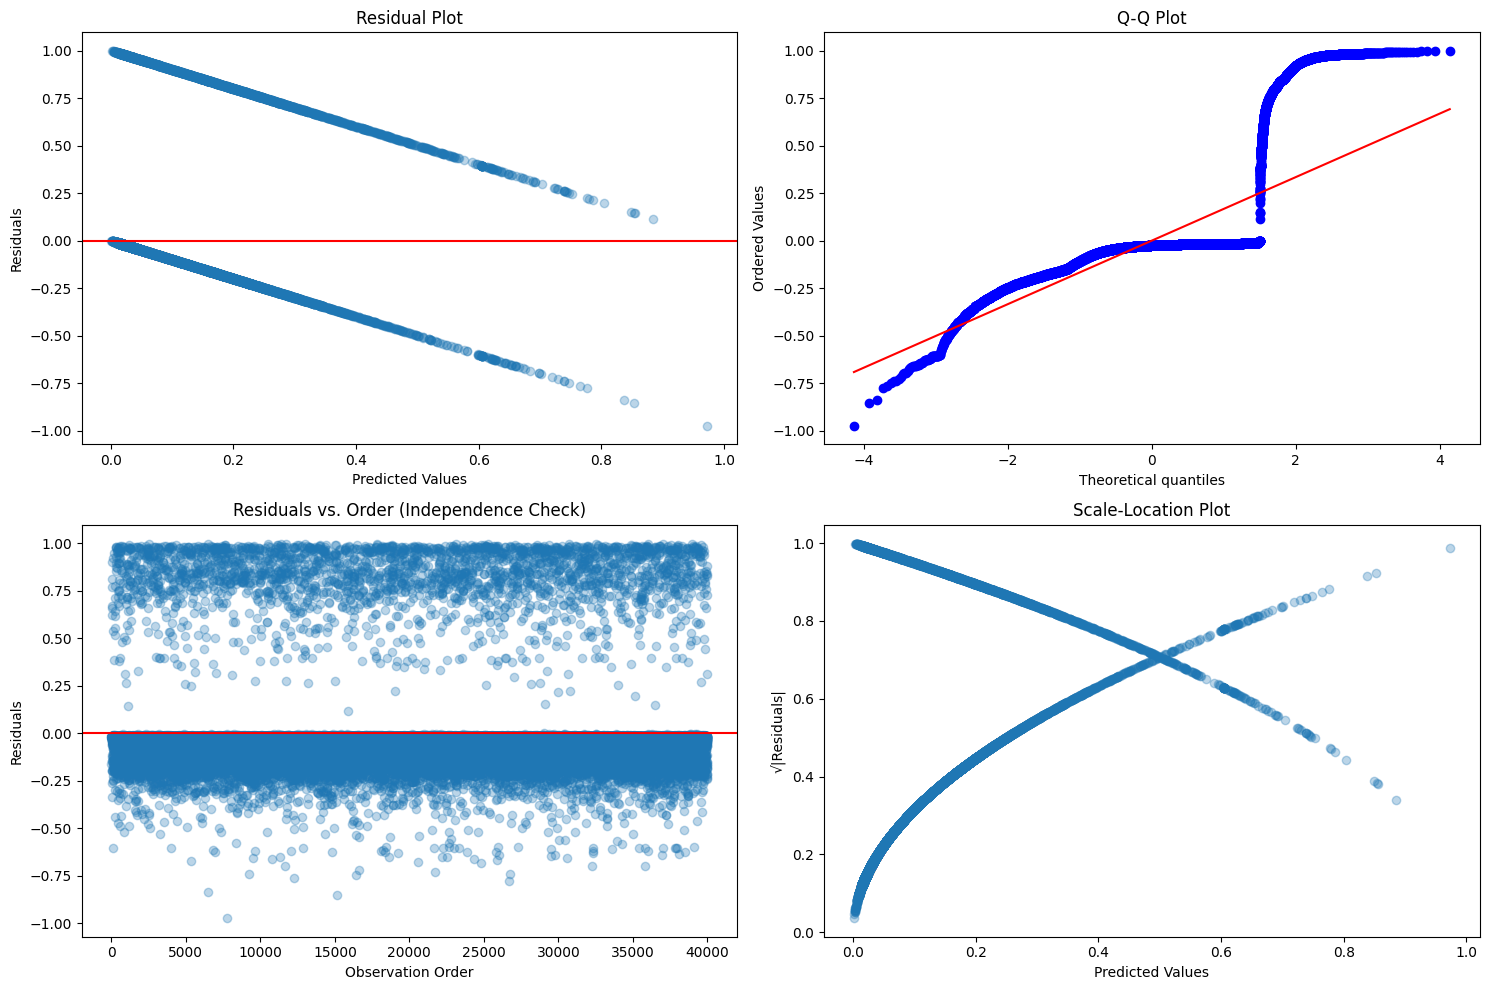

Statistic: 0.5059877505572115, p-value: 3.2718609252094987e-135
Residuals are not normally distributed (reject H0)
Durbin-Watson statistic: 1.9922009740740758
Value close to 2 suggests no autocorrelation
Value significantly less than 2 indicates positive autocorrelation
Value significantly greater than 2 indicates negative autocorrelation


In [26]:
y_pred = (y_pred_proba > 0.5).astype(int)
residuals = y_train - y_pred_proba
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(y_pred_proba, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(2, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.subplot(2, 2, 3)
plt.scatter(range(len(residuals)), residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residuals vs. Order (Independence Check)')
plt.xlabel('Observation Order')
plt.ylabel('Residuals')

plt.subplot(2, 2, 4)
plt.scatter(y_pred_proba, np.sqrt(np.abs(residuals)), alpha=0.3)
plt.title('Scale-Location Plot')
plt.xlabel('Predicted Values')
plt.ylabel('√|Residuals|')

plt.tight_layout()
plt.show()

stat, p = shapiro(residuals)
print(f'Statistic: {stat}, p-value: {p}')
if p < 0.05:
    print("Residuals are not normally distributed (reject H0)")
else:
    print("Residuals appear to be normally distributed (fail to reject H0)")

dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw}')
print("Value close to 2 suggests no autocorrelation")
print("Value significantly less than 2 indicates positive autocorrelation")
print("Value significantly greater than 2 indicates negative autocorrelation")


### **Final Feature Selection**

In [27]:
final_features = [feature for feature in rfe_features if feature in vif_data[vif_data["VIF"] < 10]["Feature"].tolist()]

print(f"Final selected features ({len(final_features)}):")
for i, feature in enumerate(final_features, 1):
    print(f"{i}. {feature}")

X_train_final = X_train[final_features]
X_test_final = X_test[final_features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

print(f"\nFinal training data shape: {X_train_scaled.shape}")
print(f"Final testing data shape: {X_test_scaled.shape}")

Final selected features (5):
1. NumberRealEstateLoansOrLines
2. NumberOfDependents
3. Credit_Per_Income
4. Credit_Per_Person
5. MonthlyIncome_Log

Final training data shape: (40000, 5)
Final testing data shape: (10000, 5)


In [28]:
smote = SMOTE(random_state=42)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

In [29]:
def eval(model, X_train, X_test, y_train, y_test, name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_train_proba = y_train_pred
        y_test_proba = y_test_pred

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Testing Accuracy: {test_acc:.4f}")
    print(f"Training AUC-ROC: {train_auc:.4f}")
    print(f"Testing AUC-ROC: {test_auc:.4f}")

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    plt.figure(figsize=(8, 6))
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_test_proba)
    plt.plot(false_positive_rate, true_positive_rate, label=f'{name} (AUC = {test_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend()
    plt.show()

    return {
        'model': model,
        'name': name,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_auc': train_auc,
        'test_auc': test_auc
    }



# ***KNN***

In [30]:
knn_model = KNeighborsClassifier(n_neighbors=4)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)
print("\n--- KNN Classifier Performance ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


--- KNN Classifier Performance ---
Accuracy: 0.8154
F1 Score: 0.8452
Precision: 0.8808
Recall: 0.8154
Confusion Matrix:
 [[8021 1310]
 [ 536  133]]


In [49]:
xtrainsummary = shap.kmeans(X_train_scaled, 10)
explainer = shap.KernelExplainer(knn_model.predict_proba, xtrainsummary)
shap_values = explainer.shap_values(X_train_scaled)

  0%|          | 0/74644 [00:00<?, ?it/s]

# ***From the Two shap graphs we can say that MonthlyIncome_Logis the most important one as it affect both postive and negative classes***

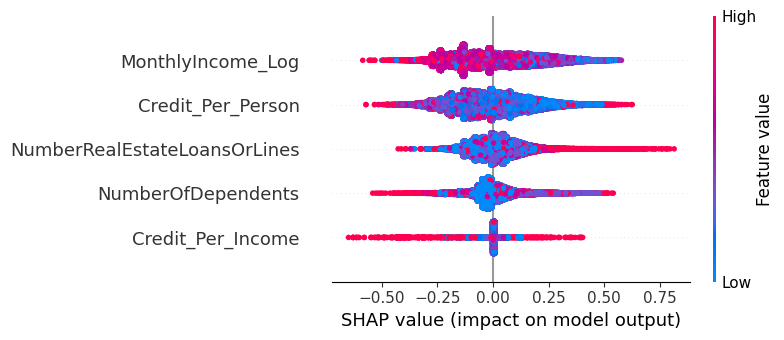

Text(0.5, 1.0, 'SHAP Values for Predicting Delinquency (Class 1)')

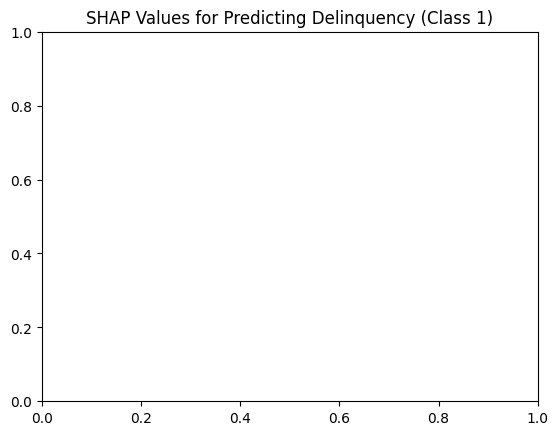

In [50]:
shap_values_array = np.array(shap_values)
class_idx = 1
shap_values_for_class = shap_values_array.take(class_idx, axis=2)
X_train_df = pd.DataFrame(X_train_scaled, columns=final_features)
shap.summary_plot(shap_values_for_class, X_train_df, max_display=100, plot_type='dot')
plt.title("SHAP Values for Predicting Delinquency (Class 1)")

# ***SHAP 2***

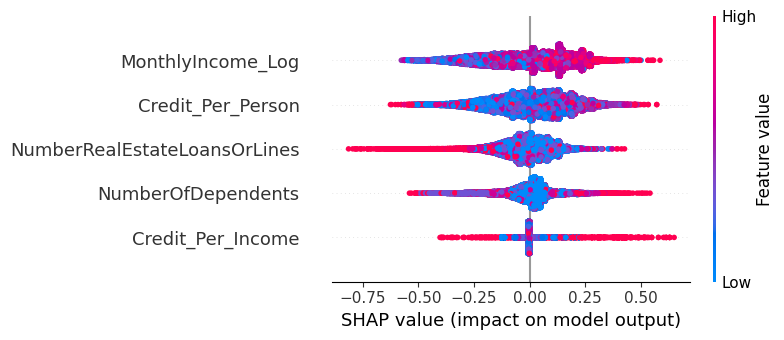

Text(0.5, 1.0, 'SHAP Values for Predicting Delinquency (Class 0)')

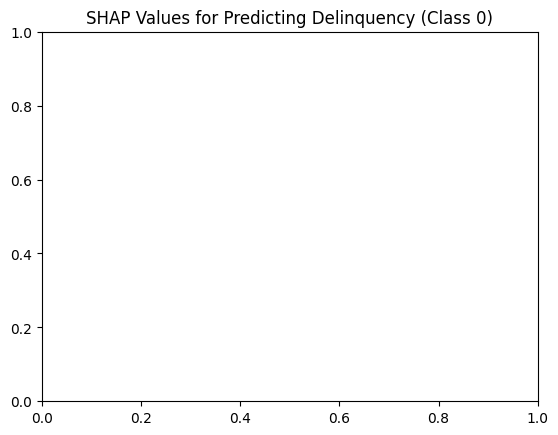

In [51]:
shap_values_array = np.array(shap_values)
class_idx = 0
shap_values_for_class = shap_values_array.take(class_idx, axis=2)
X_train_df = pd.DataFrame(X_train_scaled, columns=final_features)
shap.summary_plot(shap_values_for_class, X_train_df, max_display=100, plot_type='dot')
plt.title("SHAP Values for Predicting Delinquency (Class 0)")

# ***LIME***

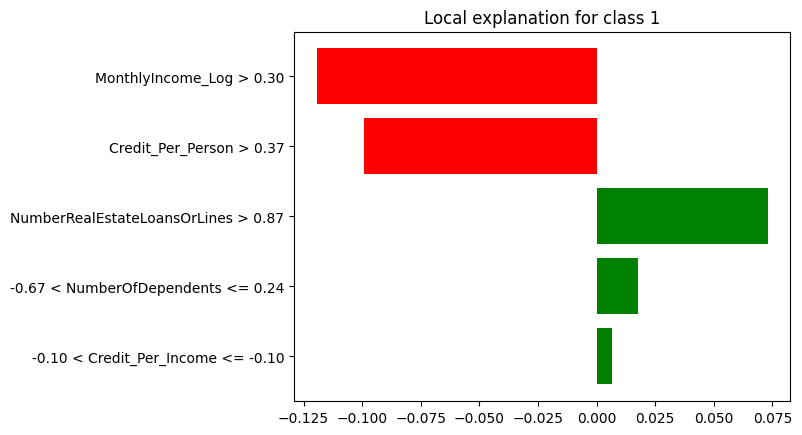


Feature Importance:
[('MonthlyIncome_Log > 0.30', -0.11940246301657907), ('Credit_Per_Person > 0.37', -0.09932527969169622), ('NumberRealEstateLoansOrLines > 0.87', 0.0729017547662965), ('-0.67 < NumberOfDependents <= 0.24', 0.01752010039831376), ('-0.10 < Credit_Per_Income <= -0.10', 0.006732921365546222)]


In [52]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train_scaled,
    feature_names=final_features,
    class_names=[0, 1],
    mode='classification'
)
instance = X_test_scaled[0]
exp = explainer.explain_instance(instance, knn_model.predict_proba, num_features=len(final_features))
exp.as_pyplot_figure()
plt.show()
print("\nFeature Importance:")
print(exp.as_list())

# ***based on the lime graph we can conclude the following***

MonthlyIncome_Log > 0.30 (strongest negative)
NumberRealEstateLoansOrLines > 0.87 (strongest positive impact)

# ***PDP***

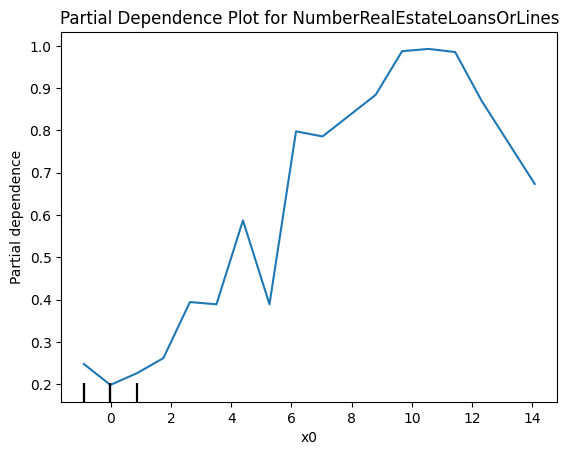

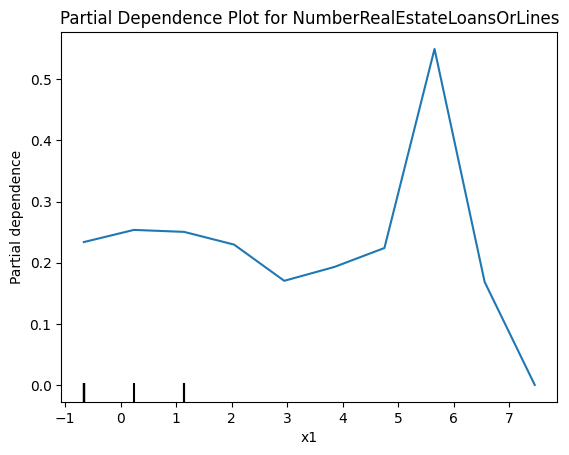

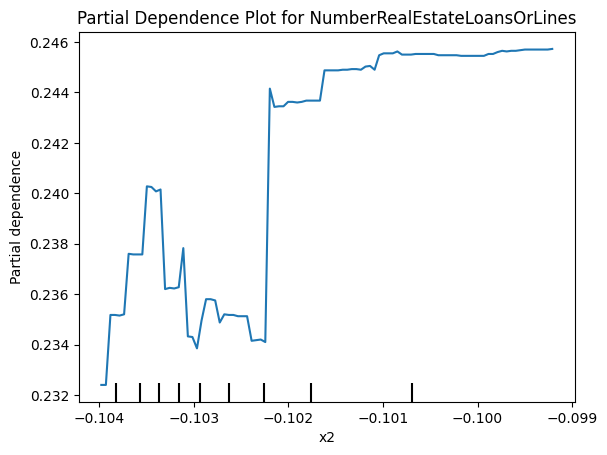

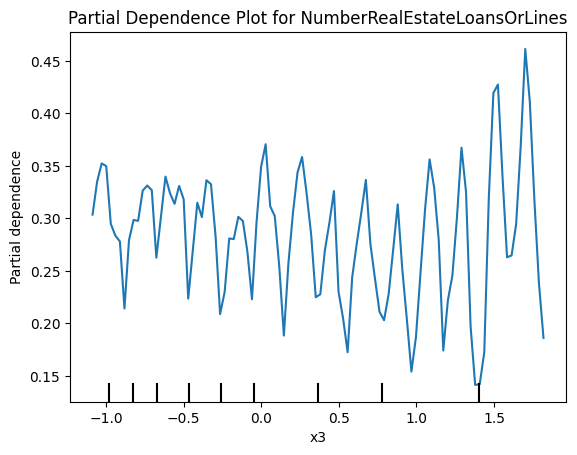

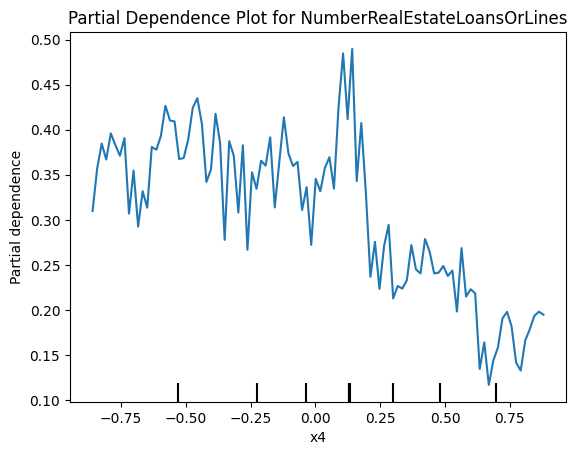

In [53]:
feature = [0]  ##NumberRealEstateLoansOrLines
PartialDependenceDisplay.from_estimator(knn_model, X_test_scaled, features=feature)
plt.title(f"Partial Dependence Plot for {final_features[0]}")
plt.show()
feature = [1]  ##NumberOfDependents
PartialDependenceDisplay.from_estimator(knn_model, X_test_scaled, features=feature)
plt.title(f"Partial Dependence Plot for {final_features[1]}")
plt.show()
feature = [2]  ##Credit_Per_Income
PartialDependenceDisplay.from_estimator(knn_model, X_test_scaled, features=feature)
plt.title(f"Partial Dependence Plot for {final_features[2]}")
plt.show()
feature = [3]  ##Credit_Per_Person
PartialDependenceDisplay.from_estimator(knn_model, X_test_scaled, features=feature)
plt.title(f"Partial Dependence Plot for {final_features[3]}")
plt.show()
feature = [4]  ## MonthlyIncome_Log
PartialDependenceDisplay.from_estimator(knn_model, X_test_scaled, features=feature)
plt.title(f"Partial Dependence Plot for {final_features[4]}")
plt.show()


# **ICE PLOTS***

<Figure size 1000x600 with 0 Axes>

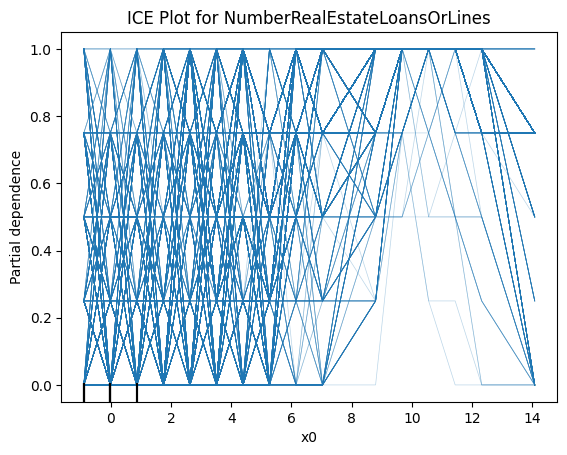

<Figure size 1000x600 with 0 Axes>

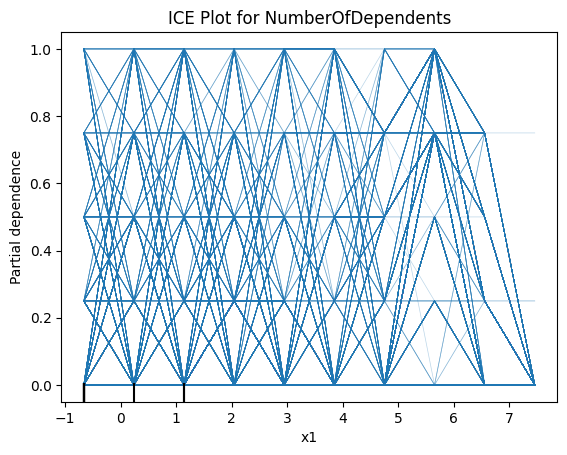

<Figure size 1000x600 with 0 Axes>

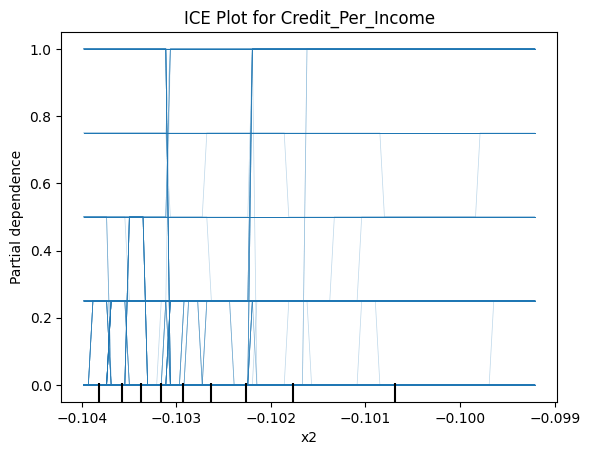

<Figure size 1000x600 with 0 Axes>

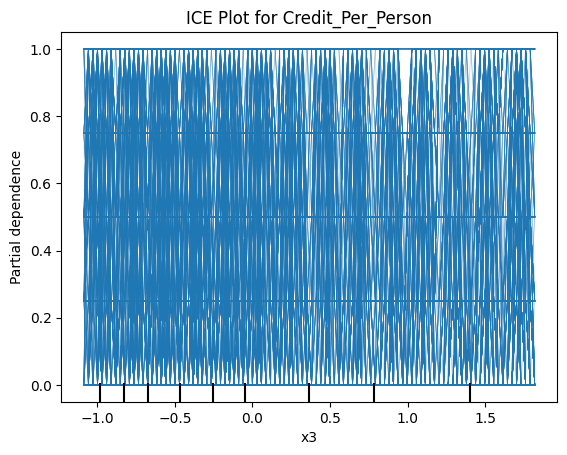

<Figure size 1000x600 with 0 Axes>

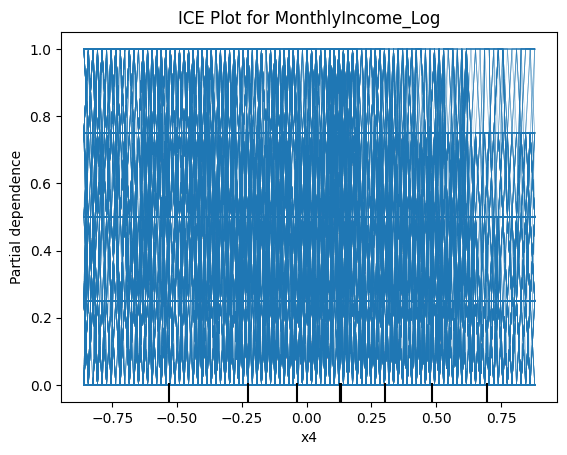

In [60]:
feature = [0]  ##NumberRealEstateLoansOrLines
plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    knn_model,
    X_test_scaled,
    features=feature,
    kind='individual'
)
plt.title(f"ICE Plot for {final_features[0]}")
plt.show()
feature = [1]  ##NumberOfDependents
plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    knn_model,
    X_test_scaled,
    features=feature,
    kind='individual'
)
plt.title(f"ICE Plot for {final_features[1]}")
plt.show()
feature = [2]  ###Credit_Per_Income
plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    knn_model,
    X_test_scaled,
    features=feature,
    kind='individual'
)
plt.title(f"ICE Plot for {final_features[2]}")
plt.show()
feature = [3]  ##Credit_Per_Person
plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    knn_model,
    X_test_scaled,
    features=feature,
    kind='individual'
)
plt.title(f"ICE Plot for {final_features[3]}")
plt.show()
feature = [4]  ### MonthlyIncome_Log
plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    knn_model,
    X_test_scaled,
    features=feature,
    kind='individual'
)
plt.title(f"ICE Plot for {final_features[4]}")
plt.show()

In [61]:
perm = PermutationImportance(knn_model, random_state=42, n_iter=10)
perm.fit(X_test_scaled, y_test)
eli5.show_weights(perm, feature_names=final_features)
##Credit_Per_Person
##Credit_Per_Income are the most two important features

Weight,Feature
0.0195 ± 0.0084,Credit_Per_Person
0.0163 ± 0.0010,Credit_Per_Income
0.0156 ± 0.0049,NumberOfDependents
0.0125 ± 0.0053,MonthlyIncome_Log
0.0077 ± 0.0052,NumberRealEstateLoansOrLines
